# Get NeRF-- Library

In [1]:
!git clone https://github.com/ActiveVisionLab/nerfmm.git

fatal: destination path 'nerfmm' already exists and is not an empty directory.


# Load Libraries

In [2]:
import os, random, cv2, datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
# from torch.utils.tensorboard import SummaryWriter
import numpy as np
import imageio
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython.display import Image

## NeRF-- Libraries
- positional encoding
- volume sampling
- volume rendering
- ray direction computing

More details can be found here: [git repo](https://https://github.com/ActiveVisionLab/nerfmm).

In [3]:
from nerfmm.utils.pos_enc import encode_position
from nerfmm.utils.volume_op import volume_rendering, volume_sampling_ndc
from nerfmm.utils.comp_ray_dir import comp_ray_dir_cam_fxfy

# Utils
from nerfmm.utils.training_utils import mse2psnr
from nerfmm.utils.lie_group_helper import convert3x4_4x4

# Setup Random Seed

In [4]:
random.seed(17)
np.random.seed(17)
torch.manual_seed(17)

# Ensures algorithm picked is deterministic each time app is run.
torch.backends.cudnn.deterministic = True

# Results can be reproduced across multiple execution, at the cost of "reduced" performance.
torch.backends.cudnn.benchmark = False

# Load Images
Load the images within the "custom_upload" folder.

In [5]:
def load_imgs(image_dir):
    img_names = np.array(sorted(os.listdir(image_dir)))  # all image names
    img_paths = np.core.defchararray.add(image_dir, img_names) # Path to images
    
    # Images fixed to 400x400, any larger and GPU will run out of space.
    H, W = 400, 400
    N_imgs = len(img_paths)

    img_list = []
    for p in img_paths:
        img = imageio.imread(p)[:,:, :3] # (H, W, 3) np.uint8
        img_list.append(cv2.resize(img, (H, W)))
    img_list = np.stack(img_list) # (N, H, W, 3)
    img_list = torch.from_numpy(img_list).float() / 255  # (N, H, W, 3) torch.float32

    results = {
        'imgs': img_list,  # (N, H, W, 3) torch.float32
        'img_names': img_names,  # (N, )
        'N_imgs': N_imgs,
        'H': H,
        'W': W,
    }
    return results


C:\Users\nguyent68\AppData\Local\Temp\ipykernel_2400\1938645975.py:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(p)[:,:, :3] # (H, W, 3) np.uint8


Loaded 6 imgs, resolution 400 x 400
torch.Size([6, 400, 400, 3])


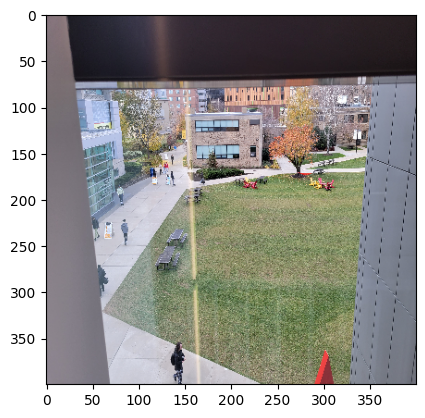

In [6]:
scene_name = "resulting_quad1"
image_dir = os.path.join(os.getcwd(),'custom_upload/')
image_data = load_imgs(image_dir)

imgs = image_data['imgs']
img_names = image_data['img_names']
N_imgs = image_data['N_imgs']
H, W = image_data['H'], image_data['W']

print('Loaded {0} imgs, resolution {1} x {2}'.format(N_imgs, H, W))
print(imgs.shape)
plt.imshow(imgs[0])

# Define Models
Unlike traditional NeRF, NeRF-- has 3 models that it needs to train: Focal, Pose, and the NeRF model.

## Define Learnable Focals

We initialise $f_x = W$ and $f_y = H$.

In practice, two coeffcients are initialised at $1.0$ and multiplied with the input image size. We also found a $2^{nd}$-order trick provides slightly better results, but it's not necessary. For more details about the $2^{nd}$-order trick, see the supplementary section in our [arxiv paper](https://https://arxiv.org/abs/2102.07064).

In [7]:
class LearnFocal(nn.Module):
    def __init__(self, H, W, req_grad):
        super(LearnFocal, self).__init__()
        self.H = H
        self.W = W

        # TODO: Test 2nd-order and see if it improves model.
        self.fx = nn.Parameter(torch.tensor(1.0, dtype=torch.float32), requires_grad=req_grad)
        self.fy = nn.Parameter(torch.tensor(1.0, dtype=torch.float32), requires_grad=req_grad)

    def forward(self):
        fxfy = torch.stack([self.fx**2 * self.W, self.fy**2 * self.H])
        return fxfy

## Define learnable POSES

Given $N$ input images, we learn a camera pose for each of them. Camera rotations are optimised in axis-angle representation and translations are optimised in Euclidean space.

In [8]:
def vec2skew(v):
    """
    :param v:  (3, ) torch tensor
    :return:   (3, 3)
    """
    zero = torch.zeros(1, dtype=torch.float32, device=v.device)
    skew_v0 = torch.cat([ zero,    -v[2:3],   v[1:2]])  # (3, 1)
    skew_v1 = torch.cat([ v[2:3],   zero,    -v[0:1]])
    skew_v2 = torch.cat([-v[1:2],   v[0:1],   zero])
    skew_v = torch.stack([skew_v0, skew_v1, skew_v2], dim=0)  # (3, 3)
    return skew_v  # (3, 3)


def Exp(r):
    """so(3) vector to SO(3) matrix
    :param r: (3, ) axis-angle, torch tensor
    :return:  (3, 3)
    """
    skew_r = vec2skew(r)  # (3, 3)
    norm_r = r.norm() + 1e-15
    eye = torch.eye(3, dtype=torch.float32, device=r.device)
    R = eye + (torch.sin(norm_r) / norm_r) * skew_r + ((1 - torch.cos(norm_r)) / norm_r**2) * (skew_r @ skew_r)
    return R


def make_c2w(r, t):
    """
    :param r:  (3, ) axis-angle             torch tensor
    :param t:  (3, ) translation vector     torch tensor
    :return:   (4, 4)
    """
    R = Exp(r)  # (3, 3)
    c2w = torch.cat([R, t.unsqueeze(1)], dim=1)  # (3, 4)
    c2w = convert3x4_4x4(c2w)  # (4, 4)
    return c2w


class LearnPose(nn.Module):
    def __init__(self, num_cams, learn_R, learn_t):
        super(LearnPose, self).__init__()
        self.num_cams = num_cams
        self.r = nn.Parameter(torch.zeros(size=(num_cams, 3), dtype=torch.float32), requires_grad=learn_R)  # (N, 3)
        self.t = nn.Parameter(torch.zeros(size=(num_cams, 3), dtype=torch.float32), requires_grad=learn_t)  # (N, 3)

    def forward(self, cam_id):
        r = self.r[cam_id]  # (3, ) axis-angle
        t = self.t[cam_id]  # (3, )
        c2w = make_c2w(r, t)  # (4, 4)
        return c2w

## Define a tiny NeRF
We define a tiny NeRF for faster colab training, with following modifications:
- We use 4 linear layers (official NeRF has 8) before the RGB and density fully connect layers.
- We discard the shortcut since the tiny NeRF is quite shallow now.

In [9]:
class TinyNerf(nn.Module):
    def __init__(self, pos_in_dims, dir_in_dims, D):
        """
        :param pos_in_dims: scalar, number of channels of encoded positions
        :param dir_in_dims: scalar, number of channels of encoded directions
        :param D:           scalar, number of hidden dimensions
        """
        super(TinyNerf, self).__init__()

        self.pos_in_dims = pos_in_dims
        self.dir_in_dims = dir_in_dims

        self.layers0 = nn.Sequential(
            nn.Linear(pos_in_dims, D), nn.ReLU(),
            nn.Linear(D, D), nn.ReLU(),
            nn.Linear(D, D), nn.ReLU(),
            nn.Linear(D, D), nn.ReLU(),
            nn.Linear(D, D), nn.ReLU(),
            nn.Linear(D, D), nn.ReLU(),
            nn.Linear(D, D), nn.ReLU(),
            nn.Linear(D, D), nn.ReLU(),
        )

        self.fc_density = nn.Linear(D, 1)
        self.fc_feature = nn.Linear(D, D)
        self.rgb_layers = nn.Sequential(nn.Linear(D + dir_in_dims, D//2), nn.ReLU())
        self.fc_rgb = nn.Linear(D//2, 3)

        self.fc_density.bias.data = torch.tensor([0.1]).float()
        self.fc_rgb.bias.data = torch.tensor([0.02, 0.02, 0.02]).float()

    def forward(self, pos_enc, dir_enc):
        """
        :param pos_enc: (H, W, N_sample, pos_in_dims) encoded positions
        :param dir_enc: (H, W, N_sample, dir_in_dims) encoded directions
        :return: rgb_density (H, W, N_sample, 4)
        """
        x = self.layers0(pos_enc)  # (H, W, N_sample, D)
        density = self.fc_density(x)  # (H, W, N_sample, 1)

        feat = self.fc_feature(x)  # (H, W, N_sample, D)
        x = torch.cat([feat, dir_enc], dim=3)  # (H, W, N_sample, D+dir_in_dims)
        x = self.rgb_layers(x)  # (H, W, N_sample, D/2)
        rgb = self.fc_rgb(x)  # (H, W, N_sample, 3)

        rgb_den = torch.cat([rgb, density], dim=3)  # (H, W, N_sample, 4)
        return rgb_den

# Training Pipeline

## Set ray parameters

In [10]:
class RayParameters():
    def __init__(self):
      self.NEAR, self.FAR = 0.0, 1.0  # ndc near far
      self.N_SAMPLE = 128  # samples per ray
      self.POS_ENC_FREQ = 10  # positional encoding freq for location
      self.DIR_ENC_FREQ = 4   # positional encoding freq for direction

ray_params = RayParameters()

## Define training function
During training, two key steps enable back-propagation:
1. Compute ray directions using estimated intrinsics online.
2. Sample the 3D volume using estimated poses and intrinsics online.

We highlight those two parts in their related comments with "KEY" keyword.

In [11]:
def model_render_image(c2w, rays_cam, t_vals, ray_params, H, W, fxfy, nerf_model,
                       perturb_t, sigma_noise_std):
    """
    :param c2w:         (4, 4)                  pose to transform ray direction from cam to world.
    :param rays_cam:    (someH, someW, 3)       ray directions in camera coordinate, can be random selected
                                                rows and cols, or some full rows, or an entire image.
    :param t_vals:      (N_samples)             sample depth along a ray.
    :param perturb_t:   True/False              perturb t values.
    :param sigma_noise_std: float               add noise to raw density predictions (sigma).
    :return:            (someH, someW, 3)       volume rendered images for the input rays.
    """
    # KEY 2: sample the 3D volume using estimated poses and intrinsics online.
    # (H, W, N_sample, 3), (H, W, 3), (H, W, N_sam)
    sample_pos, _, ray_dir_world, t_vals_noisy = volume_sampling_ndc(c2w, rays_cam, t_vals, ray_params.NEAR,
                                                                     ray_params.FAR, H, W, fxfy, perturb_t)

    # encode position: (H, W, N_sample, (2L+1)*C = 63)
    pos_enc = encode_position(sample_pos, levels=ray_params.POS_ENC_FREQ, inc_input=True)

    # encode direction: (H, W, N_sample, (2L+1)*C = 27)
    ray_dir_world = F.normalize(ray_dir_world, p=2, dim=2)  # (H, W, 3)
    dir_enc = encode_position(ray_dir_world, levels=ray_params.DIR_ENC_FREQ, inc_input=True)  # (H, W, 27)
    dir_enc = dir_enc.unsqueeze(2).expand(-1, -1, ray_params.N_SAMPLE, -1)  # (H, W, N_sample, 27)

    # inference rgb and density using position and direction encoding.
    rgb_density = nerf_model(pos_enc, dir_enc)  # (H, W, N_sample, 4)

    render_result = volume_rendering(rgb_density, t_vals_noisy, sigma_noise_std, rgb_act_fn=torch.sigmoid)
    rgb_rendered = render_result['rgb']  # (H, W, 3)
    depth_map = render_result['depth_map']  # (H, W)

    result = {
        'rgb': rgb_rendered,  # (H, W, 3)
        'depth_map': depth_map,  # (H, W)
    }

    return result

def train_one_epoch(imgs, H, W, ray_params, opt_nerf, opt_focal,
                    opt_pose, nerf_model, focal_net, pose_param_net):
    nerf_model.train()
    focal_net.train()
    pose_param_net.train()

    t_vals = torch.linspace(ray_params.NEAR, ray_params.FAR, ray_params.N_SAMPLE, device='cuda')  # (N_sample,) sample position
    L2_loss_epoch = []

    # shuffle the training imgs
    ids = np.arange(N_imgs)
    np.random.shuffle(ids)

    for i in ids:
        fxfy = focal_net()

        # KEY 1: compute ray directions using estimated intrinsics online.
        ray_dir_cam = comp_ray_dir_cam_fxfy(H, W, fxfy[0], fxfy[1])
        img = imgs[i].to('cuda')  # (H, W, 4)
        c2w = pose_param_net(i)  # (4, 4)

        # sample 32x32 pixel on an image and their rays for training.
        r_id = torch.randperm(H, device='cuda')[:32]  # (N_select_rows)
        c_id = torch.randperm(W, device='cuda')[:32]  # (N_select_cols)
        ray_selected_cam = ray_dir_cam[r_id][:, c_id]  # (N_select_rows, N_select_cols, 3)
        img_selected = img[r_id][:, c_id]  # (N_select_rows, N_select_cols, 3)

        # render an image using selected rays, pose, sample intervals, and the network
        render_result = model_render_image(c2w, ray_selected_cam, t_vals, ray_params,
                                           H, W, fxfy, nerf_model, perturb_t=True, sigma_noise_std=0.0)
        rgb_rendered = render_result['rgb']  # (N_select_rows, N_select_cols, 3)
        # print(rgb_rendered.shape)
        # print(img_selected.shape)
        L2_loss = F.mse_loss(rgb_rendered, img_selected)  # loss for one image

        L2_loss.backward()
        opt_nerf.step()
        opt_focal.step()
        opt_pose.step()
        opt_nerf.zero_grad()
        opt_focal.zero_grad()
        opt_pose.zero_grad()

        L2_loss_epoch.append(L2_loss)

    L2_loss_epoch_mean = torch.stack(L2_loss_epoch).mean().item()
    return L2_loss_epoch_mean

## Define evaluation function

We render an image from a $4\times4$ identity matrix as we do not have train/eval pose at all.

Render results can be found in the tensorboard above.

In [12]:
def render_novel_view(c2w, H, W, fxfy, ray_params, nerf_model):
    nerf_model.eval()

    ray_dir_cam = comp_ray_dir_cam_fxfy(H, W, fxfy[0], fxfy[1])
    t_vals = torch.linspace(ray_params.NEAR, ray_params.FAR, ray_params.N_SAMPLE, device='cuda')  # (N_sample,) sample position

    c2w = c2w.to('cuda')  # (4, 4)

    # split an image to rows when the input image resolution is high
    rays_dir_cam_split_rows = ray_dir_cam.split(10, dim=0)  # input 10 rows each time
    rendered_img = []
    rendered_depth = []
    for rays_dir_rows in rays_dir_cam_split_rows:
        render_result = model_render_image(c2w, rays_dir_rows, t_vals, ray_params,
                                           H, W, fxfy, nerf_model,
                                           perturb_t=False, sigma_noise_std=0.0)
        rgb_rendered_rows = render_result['rgb']  # (num_rows_eval_img, W, 3)
        depth_map = render_result['depth_map']  # (num_rows_eval_img, W)

        rendered_img.append(rgb_rendered_rows)
        rendered_depth.append(depth_map)

    # combine rows to an image
    rendered_img = torch.cat(rendered_img, dim=0)  # (H, W, 3)
    rendered_depth = torch.cat(rendered_depth, dim=0)  # (H, W)
    return rendered_img, rendered_depth

# Step 4: Actual training ⚽
- In our paper, we train our our NeRF-- for 10K epochs. but due to the limited GPU resources available in colab, we train our NeRF-- system for 200 epochs (< 10 min) for now, from which a blurry nerf and a rough estimation of camera parameters can be acquired.
- Depending on scenes, the depth estimation should start making sense at some point. All examples in this notebook should have a correct depth estimation before 200 epochs. However, we cannot guarentee similar performance for uploaded images.
- ***Despite the renderings after 200 epochs are blurry, which can be improved progressively during training, a near-far relationship should be established in 200 epochs for our prepared data in this notebook experiment***. A darker area in a depth map denotes closer distance than a brighter area.
- During training, we check if the joint optimisation is successful by writing the depth estimation to tensorboard every 50 epochs. The depth map is estimated from a camera pose that is set to identity matrix. Check the *Image* tab in the tensorboard above.


## Step 4.1: Define Models

In [13]:
def DefineModels():
  # Initialise all trainabled parameters
  focal_net = LearnFocal(H, W, req_grad=True).cuda()
  pose_param_net = LearnPose(num_cams=N_imgs, learn_R=True, learn_t=True).cuda()

  # Get a tiny NeRF model. Hidden dimension set to 128
  nerf_model = TinyNerf(pos_in_dims=63, dir_in_dims=27, D=128).cuda()

  # Set lr and scheduler: these are just stair-case exponantial decay lr schedulers.
  opt_nerf = torch.optim.Adam(nerf_model.parameters(), lr=0.001)
  opt_focal = torch.optim.Adam(focal_net.parameters(), lr=0.001)
  opt_pose = torch.optim.Adam(pose_param_net.parameters(), lr=0.001)

  from torch.optim.lr_scheduler import MultiStepLR
  scheduler_nerf = MultiStepLR(opt_nerf, milestones=list(range(0, 10000, 10)), gamma=0.9954)
  scheduler_focal = MultiStepLR(opt_focal, milestones=list(range(0, 10000, 100)), gamma=0.9)
  scheduler_pose = MultiStepLR(opt_pose, milestones=list(range(0, 10000, 100)), gamma=0.9)
  return nerf_model, opt_nerf, scheduler_nerf, focal_net, opt_focal, scheduler_focal, pose_param_net, opt_pose, scheduler_pose

In [14]:
(nerf_model, opt_nerf, scheduler_nerf, focal_net, opt_focal, scheduler_focal, pose_param_net, opt_pose, scheduler_pose) = DefineModels()

## Step 4.2: Train!

In [15]:
N_EPOCH = 2000  # set to 1000 to get slightly better results. we use 10K epoch in our paper.
EVAL_INTERVAL = 50  # render an image to visualise for every this interval.

psnr_Results = []
def train_models(imgs, ray_params, opt_nerf, opt_focal, 
                 opt_pose, nerf_model, focal_net, pose_param_net):
    # Store poses to visualise them later
    pose_history = []

    # Training
    print('Training... Check results in the tensorboard above.')
    for epoch_i in tqdm(range(N_EPOCH), desc='Training'):
        L2_loss = train_one_epoch(imgs, H, W, ray_params, opt_nerf, opt_focal,
                                opt_pose, nerf_model, focal_net, pose_param_net)
        train_psnr = mse2psnr(L2_loss)
        psnr_Results.append(train_psnr)
        # writer.add_scalar('train/psnr', train_psnr, epoch_i)

        fxfy = focal_net()
        # print('epoch {0:4d} Training PSNR {1:.3f}, estimated fx {2:.1f} fy {3:.1f}'.format(epoch_i, train_psnr, fxfy[0], fxfy[1]))

        scheduler_nerf.step()
        scheduler_focal.step()
        scheduler_pose.step()

        learned_c2ws = torch.stack([pose_param_net(i) for i in range(N_imgs)])  # (N, 4, 4)
        pose_history.append(learned_c2ws[:, :3, 3])  # (N, 3) only store positions as we vis in 2D.

        with torch.no_grad():
            if (epoch_i+1) % EVAL_INTERVAL == 0:
                eval_c2w = torch.eye(4, dtype=torch.float32)  # (4, 4)
                fxfy = focal_net()
                rendered_img, rendered_depth = render_novel_view(eval_c2w, H, W, fxfy, ray_params, nerf_model)
                # writer.add_image('eval/img', rendered_img.permute(2, 0, 1), global_step=epoch_i)
                # writer.add_image('eval/depth', rendered_depth.unsqueeze(0), global_step=epoch_i)

    pose_history = torch.stack(pose_history).detach().cpu().numpy()  # (N_epoch, N_img, 3)
    print('Training finished.')
    return pose_history

In [21]:
pose_history = train_models(imgs, ray_params, opt_nerf, opt_focal, opt_pose, nerf_model, focal_net, pose_param_net)

Training... Check results in the tensorboard above.


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

Training finished.


Text(0, 0.5, 'Peak Signal-To-Noise Ratio (PSNR)')

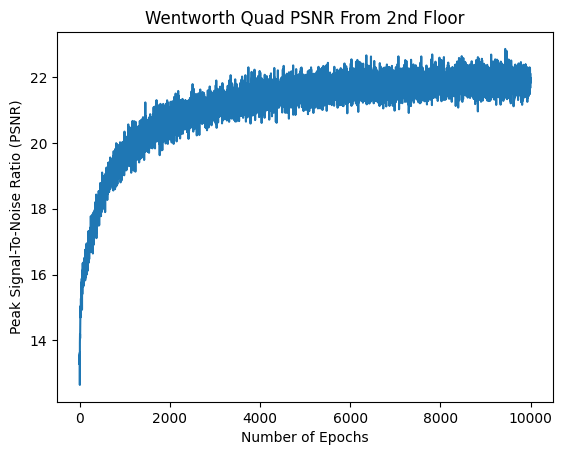

In [22]:
import matplotlib.pyplot as plt

plt.plot(np.arange(0, N_EPOCH*5), psnr_Results)
plt.title("Wentworth Quad PSNR From 2nd Floor")
plt.xlabel("Number of Epochs")
plt.ylabel("Peak Signal-To-Noise Ratio (PSNR)")

## Step 5: Novel View Synthesis 🖼️

In [23]:
# Render novel views from a sprial camera trajectory.
# The spiral trajectory generation function is modified from https://github.com/kwea123/nerf_pl.
from nerfmm.utils.pose_utils import create_spiral_poses

def view_synthesis(nerf_model, focal_net, pose_param_net, ray_params):
    # Render full images are time consuming, especially on colab so we render a smaller version instead.
    resize_ratio = 4
    with torch.no_grad():
        optimised_poses = torch.stack([pose_param_net(i) for i in range(N_imgs)])
        radii = np.percentile(np.abs(optimised_poses.cpu().numpy()[:, :3, 3]), q=50, axis=0)  # (3,)
        spiral_c2ws = create_spiral_poses(radii, focus_depth=3.5, n_poses=30, n_circle=1)
        spiral_c2ws = torch.from_numpy(spiral_c2ws).float()  # (N, 3, 4)

        # change intrinsics according to resize ratio
        fxfy = focal_net()
        novel_fxfy = fxfy / resize_ratio
        novel_H, novel_W = H // resize_ratio, W // resize_ratio

        print('NeRF trained in {0:d} x {1:d} for {2:d} epochs'.format(H, W, N_EPOCH))
        print('Rendering novel views in {0:d} x {1:d}'.format(novel_H, novel_W))

        novel_img_list, novel_depth_list = [], []
        for i in tqdm(range(spiral_c2ws.shape[0]), desc='novel view rendering'):
            novel_img, novel_depth = render_novel_view(spiral_c2ws[i], novel_H, novel_W, novel_fxfy,
                                                    ray_params, nerf_model)
            novel_img_list.append(novel_img)
            plt.imshow(novel_img.cpu().data.numpy())
            plt.show()
            novel_depth_list.append(novel_depth)

        print('Novel view rendering done. Saving to GIF images...')
        novel_img_list = (torch.stack(novel_img_list) * 255).cpu().numpy().astype(np.uint8)
        novel_depth_list = (torch.stack(novel_depth_list) * 200).cpu().numpy().astype(np.uint8)  # depth is always in 0 to 1 in NDC

        os.makedirs('nvs_results', exist_ok=True)
        imageio.mimwrite(os.path.join('nvs_results', scene_name + '_img.gif'), novel_img_list, fps=30)
        imageio.mimwrite(os.path.join('nvs_results', scene_name + '_depth.gif'), novel_depth_list, fps=30)
    print('GIF images saved.')

NeRF trained in 400 x 400 for 2000 epochs
Rendering novel views in 100 x 100


novel view rendering:   0%|          | 0/30 [00:00<?, ?it/s]

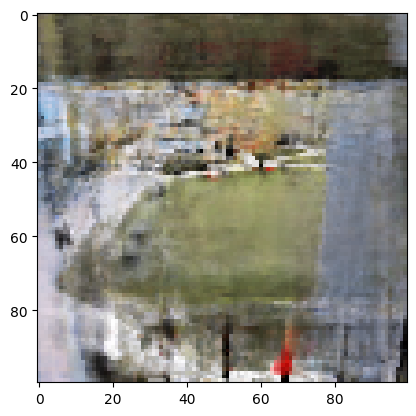

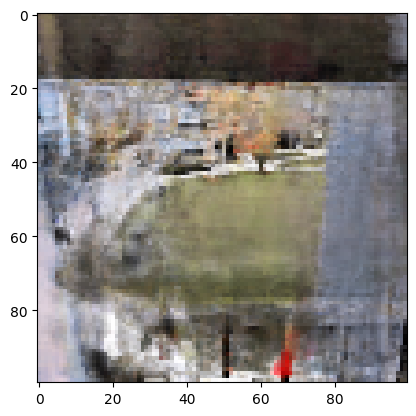

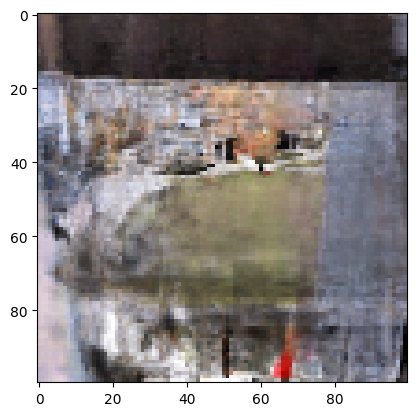

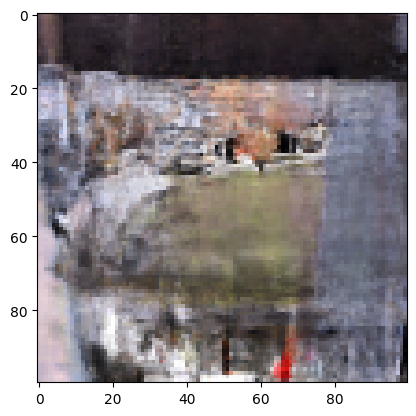

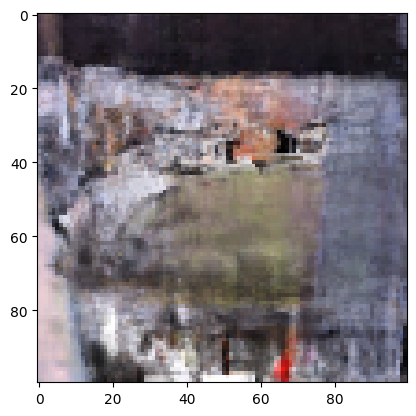

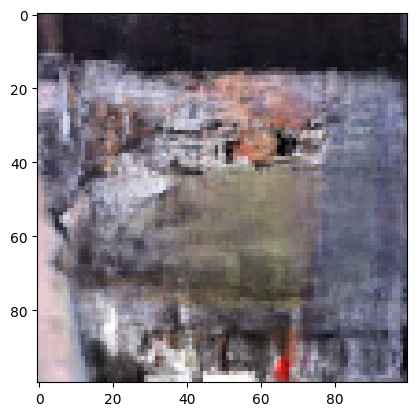

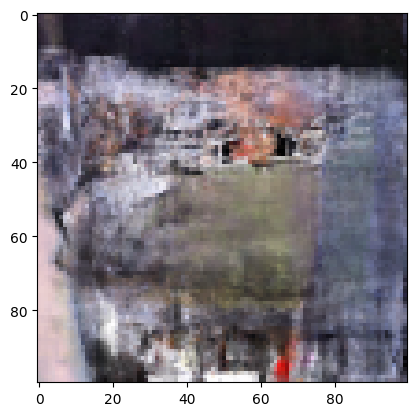

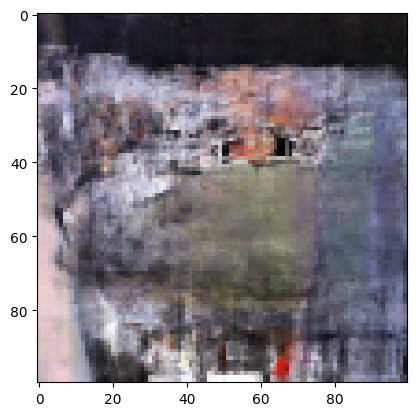

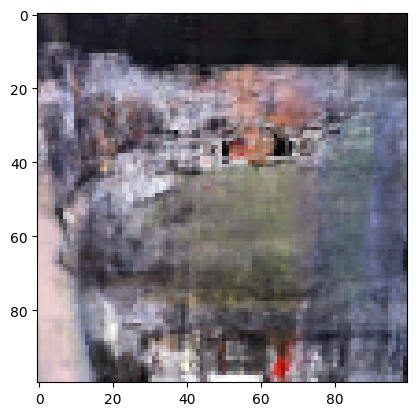

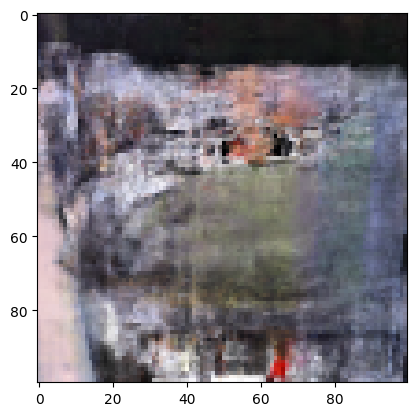

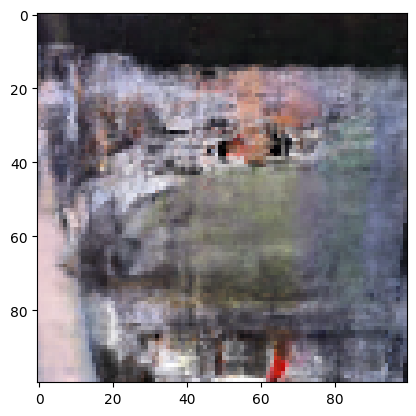

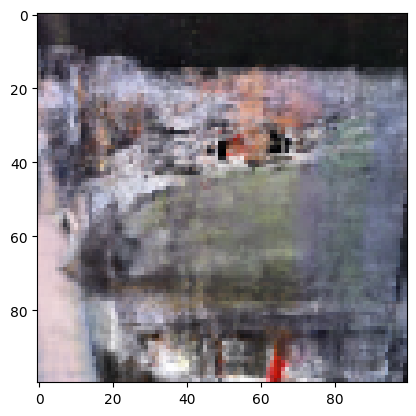

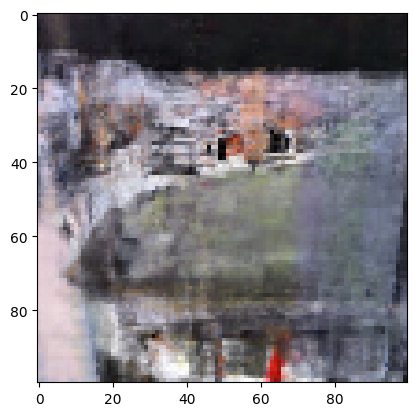

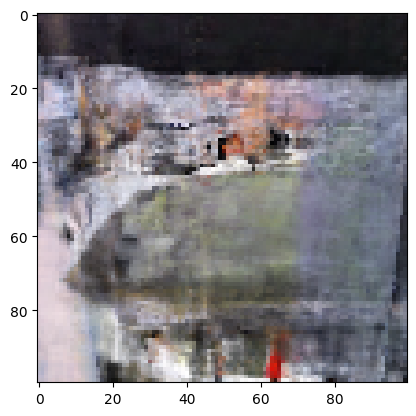

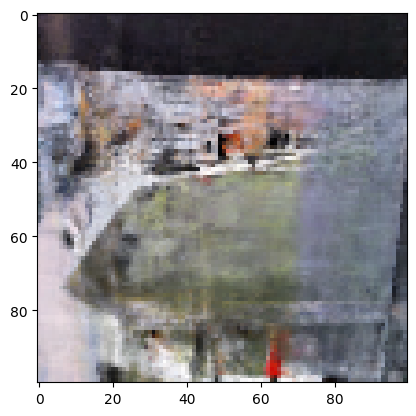

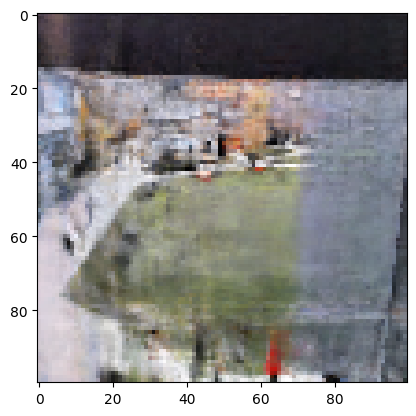

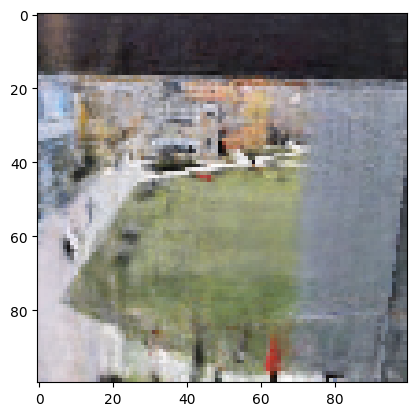

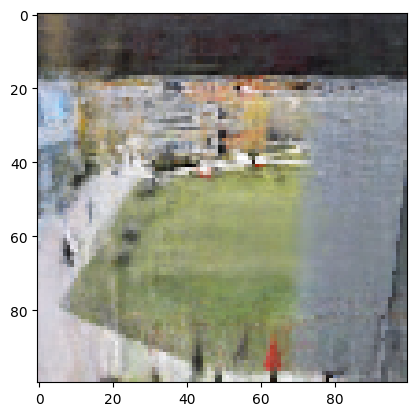

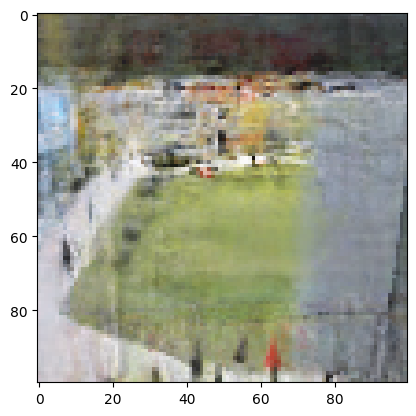

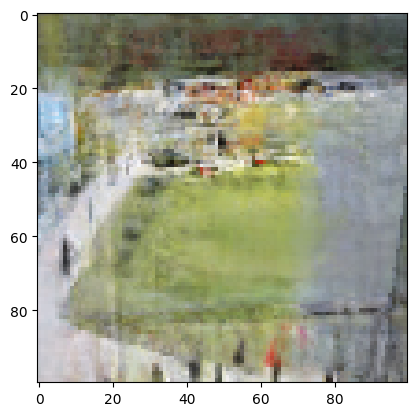

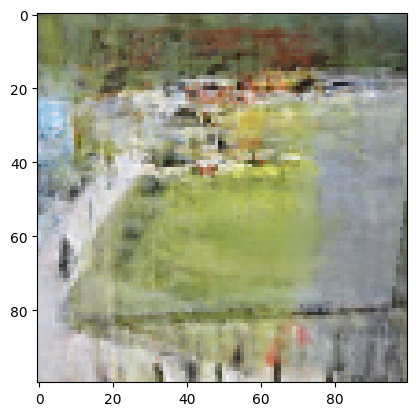

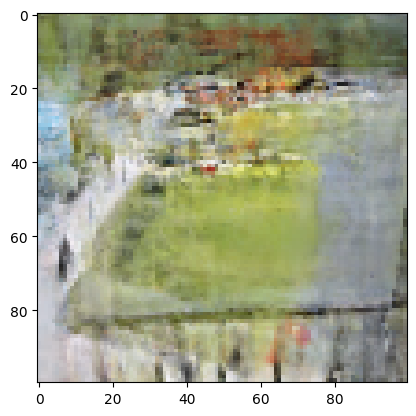

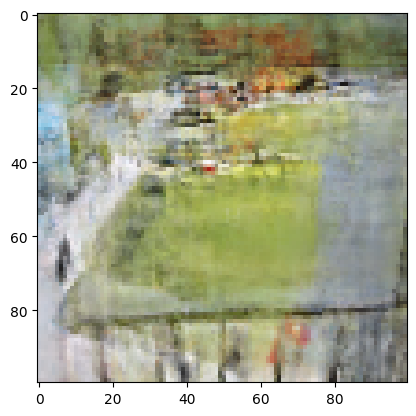

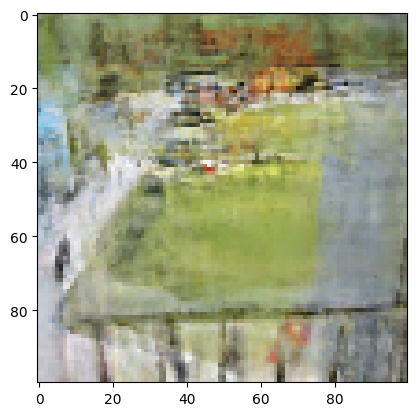

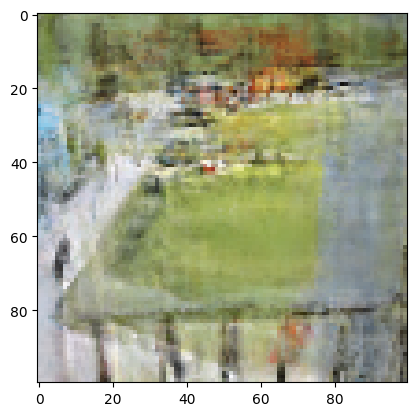

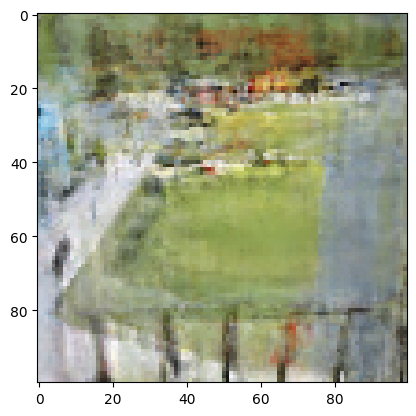

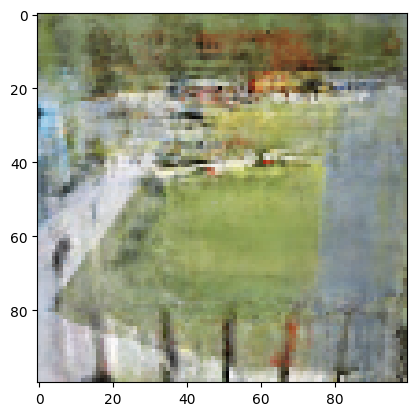

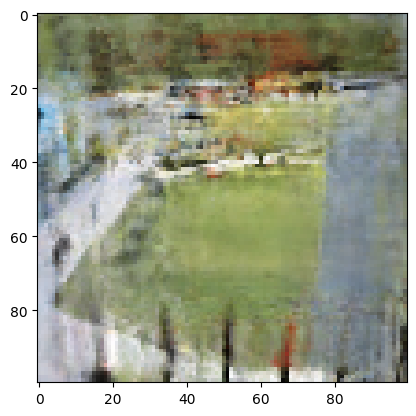

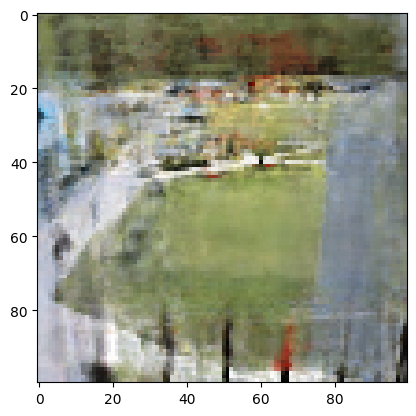

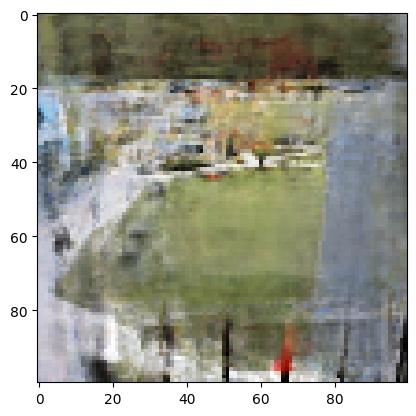

Novel view rendering done. Saving to GIF images...
GIF images saved.


In [24]:
view_synthesis(nerf_model, focal_net, pose_param_net, ray_params)

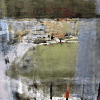

In [29]:
Image(open(os.path.join('nvs_results', scene_name + '_img.gif'), 'rb').read())

In [ ]:
Image(open(os.path.join('nvs_results', scene_name + '_depth.gif'), 'rb').read())

## Step 6: Visualise Camera Poses 📷

We visualise the optimisation process of camera poses from Z direction, i.e. on 2D XY-plane.

In [ ]:
%matplotlib inline
from matplotlib import animation
from IPython.display import HTML

fig = plt.figure(figsize=(6, 6))
ax0 = plt.subplot(111)
ax0.set_xlim((-0.5, 0.5))
ax0.set_ylim((-0.5, 0.5))
ax0.set_xlabel('X')
ax0.set_ylabel('Y')
ax0.grid(ls='--', color='0.7')

title = ax0.set_title('')
traj_line, = ax0.plot([], [], c='blue', ls='-', marker='^', linewidth=0.7, markersize=4)

def drawframe(fr_id):
    """
    :param fr_id: frame id
    :param poses: (N_img, 3) camera positions
    """
    poses = pose_history[fr_id]
    traj_line.set_data(poses[:, 0], poses[:, 1])
    title.set_text('epoch {0:4d}'.format(fr_id))
    return (traj_line,)

anim = animation.FuncAnimation(fig, drawframe, frames=N_EPOCH, interval=100)

plt.close(anim._fig)
HTML(anim.to_html5_video())

# Save Models

In [ ]:
torch.save({'model': nerf_model.state_dict(),
              'opt': opt_nerf.state_dict(),
              'lr': scheduler_nerf.state_dict(),  # you also need to save the state of the learning rate scheduler
             }, "NeRF_Model")

torch.save({'model': focal_net.state_dict(),
              'opt': opt_focal.state_dict(),
              'lr': scheduler_focal.state_dict(),  # you also need to save the state of the learning rate scheduler
             }, "Focal_Model")

torch.save({'model': pose_param_net.state_dict(),
              'opt': opt_pose.state_dict(),
              'lr': scheduler_pose.state_dict(),  # you also need to save the state of the learning rate scheduler
             }, "Pose_Model")

# Load Models

In [ ]:
nerf_state_dicts = torch.load("NeRF_Model_Libya")

focal_state_dicts = torch.load("Focal_Model_Libya")

pose_state_dicts = torch.load("Pose_Model_Libya")

## Load States

In [ ]:
(trained_nerf_model, trained_opt_nerf, trained_scheduler_nerf, 
 trained_focal_net, trained_opt_focal, trained_scheduler_focal, 
 trained_pose_param_net, trained_opt_pose, trained_scheduler_pose) = DefineModels()

In [ ]:
trained_nerf_model.load_state_dict(nerf_state_dicts['model'])
trained_opt_nerf.load_state_dict(nerf_state_dicts['opt'])
trained_scheduler_nerf.load_state_dict(nerf_state_dicts['lr'])

trained_focal_net.load_state_dict(focal_state_dicts['model'])
trained_opt_focal.load_state_dict(focal_state_dicts['opt'])
trained_scheduler_focal.load_state_dict(focal_state_dicts['lr'])

trained_pose_param_net.load_state_dict(pose_state_dicts['model'])
trained_opt_pose.load_state_dict(pose_state_dicts['opt'])
trained_scheduler_pose.load_state_dict(pose_state_dicts['lr'])

# Continue Training Pretrained Models

In [ ]:
pose_history = train_models(imgs, ray_params, trained_opt_nerf, trained_opt_focal, trained_opt_pose, trained_nerf_model, trained_focal_net, trained_pose_param_net)

In [ ]:
scene_name = "results5"
view_synthesis(trained_nerf_model, trained_focal_net, trained_pose_param_net, ray_params)